In [1]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing import image

Using TensorFlow backend.
/Users/reubenfeinman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [26]:
from learning2learn.images import generate_image, generate_random_shape, Texture

def generate_texture(patch_type=None, gradient='sample', image_size=500):
    """

    :param patch_type:
    :param gradient:
    :param image_size:
    :return:
    """
    if patch_type is None:
        # randomly sample a patch type
        patch_types = [
            'ellipse', 'arc', 'arrow', 'circle',
            'rectangle', 'wedge', 'pentagon',
            '/', '//', '-', '--', '+', '++'
        ]
        patch_type = np.random.choice(patch_types)
    # Patch size will be uniformly sampled. Let's define
    # reasonable boundaries here
    patch_min_size = int(0.03*image_size)
    patch_max_size = int(0.09*image_size)
    # Now, build the texture object according to the specified type
    if patch_type == 'circle':
        params = {
            'radius': randint(patch_min_size, patch_max_size)
        }
    elif patch_type in ['rectangle', 'ellipse', 'arc']:
        params = {
            'height': randint(patch_min_size, patch_max_size),
            'width': randint(2*patch_min_size, 2*patch_max_size),
            'angle': randint(0, 180)
        }
    elif patch_type == 'pentagon':
        params = {
            'radius': randint(patch_min_size, patch_max_size)
        }
    elif patch_type == 'wedge':
        params = {
            'radius': randint(patch_min_size, patch_max_size),
            'theta2': randint(45, 270)
        }
    elif patch_type == 'arrow':
        params = {
            'dx': randint(-patch_max_size, patch_max_size),
            'dy': randint(-patch_max_size, patch_max_size),
            'width': randint(3*patch_min_size, 3*patch_max_size)
        }
    elif patch_type in ['/', '//', '-', '--', '+', '++']:
        params = None
    else:
        raise Exception('Invalid patch_type parameter.')

    if patch_type in ['ellipse', 'arc', 'arrow', 'circle','rectangle',
                      'wedge', 'pentagon']:
        # As another parameter, step size (space between
        # patches) will be uniformly sampled. Define
        # boundaries here
        step_min_size = int(0.15*image_size)
        step_max_size = int(0.30*image_size)
        # Now sample the step size. Later, we will step
        # through the image placing the patches at different
        # locations, 'step' pixels apart from one another
        step = randint(step_min_size, step_max_size)
    else:
        step = None

    if gradient == 'sample':
        # As a final parameter, we will sample a gradient from
        # a set of 5 options
        gradient_options = [None, 'left', 'right', 'up', 'down']
        gradient = np.random.choice(gradient_options)
    else:
        # In this case, the gradient has already been provided.
        # Let's error-check it.
        assert gradient in [None, 'left', 'right', 'up', 'down']

    # Now create the texture object instance and return
    return Texture(patch_type, gradient, step, params)

def generate_textures(nb_categories, image_size):
    step_min = int(0.15*image_size)
    step_max = int(0.30*image_size)
    size_min = int(0.03*image_size)
    size_max = int(0.09*image_size)
    textures = []
    # hatches
    for hatch_type in ['/', '//', '-', '--', '+', '++']:
        textures.append(Texture(hatch_type, gradient=None))
    # circles and pentagons
    for size in [6, 10, 14]:
        params = {'radius': size}
        for step in [45, 60]:
            textures.append(Texture('circle', None, step, params))
            textures.append(Texture('pentagon', None, step, params))
    # rectangles, ellipses and arcs
    for size in [6, 10, 14]:
        for angle in [0, 45, 90]:
            params = {
                'height': 1.5*size,
                'width': size,
                'angle': angle
            }
            for step in [45, 60]:
                textures.append(Texture('rectangle', None, step, params))
                textures.append(Texture('ellipse', None, step, params))
                textures.append(Texture('arc', None, step, params))
    # wedges
    for size in [6, 10, 14]:
        for theta in [180, 270]:
            params = {
                'radius': size,
                'theta2': theta
            }
            for step in [45, 60]:
                textures.append(Texture('wedge', None, step, params))
    # arrows
    for size in [6, 10, 14]:
        for width in [20, 50]:
            params = {
                'dx': size,
                'dy': size,
                'width': width
            }
            for step in [45, 60]:
                textures.append(Texture('arrow', None, step, params))
    
    return textures

def generate_dataset_parameters(nb_categories, image_size=500):
    # Generate shapes, which are sets of points for which polygons will
    # be generated
    shapes = [generate_random_shape(0, 500, 0, 500, 100) for _ in
              range(nb_categories)]
    # Generate colors, which are 3-D vectors of values between 0-1 (RGB values)
    colors = generate_colors(nb_categories)
    # Generate textures
    textures = generate_textures(nb_categories)

    return shapes, colors, textures

def create_dataset(nb_categories, nb_exemplars, data_folder):
    # Generate the set of shapes, colors and textures that we will 
    # draw from
    shape_set, color_set, texture_set = \
        generate_dataset_parameters(nb_categories)
    # Create folder where images will be stored; if exists, remove
    if os.path.isdir(data_folder):
        print('A dataset of the specified parameters already exists. Using '
              'the existing one...')
    else:
        print('Building the image dataset...')
        os.mkdir(data_folder)
        # Synthesize the dataset. Use nb_exemplars+1 because 1 exemplar
        # of each class will be used for testing.
        df, _ = synthesize_data(nb_categories, nb_exemplars+1)
        shapes = [shape_set[i] for i in df['shape']]
        colors = [color_set[i] for i in df['color']]
        textures = [texture_set[i] for i in df['texture']]
        for shape, color, texture, i in \
                zip(shapes, colors, textures, range(len(shapes))):
            save_file = os.path.join(data_folder, 'img%0.4i.png' % i)
            generate_image(shape, color, texture, save_file)
        # Save the dataset parameters so we know what we're working with
        df.to_csv(os.path.join(data_folder, 'data.csv'))

In [22]:
shape = generate_random_shape(0, 500, 0, 500, 100)
color = np.random.uniform(size=(3,))

In [27]:
textures = generate_textures(nb_categories=10, image_size=500)

In [28]:
for i in range(len(textures)):
    print(i)
    save_file = '/Users/reubenfeinman/Desktop/temp/img%0.2i.png' % i
    generate_image(shape, color, textures[i], save_file)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


In [37]:
def load_image_dataset(data_folder, target_size=(200, 200), feature_info=True):
    # First load the images
    imgs = []
    files = [file for file in os.listdir(data_folder) if file.endswith('png')]
    files = sorted(files)
    for file in files:
        img_path = os.path.join(data_folder, file)
        img = image.load_img(img_path, target_size=target_size,
                             interpolation='bicubic')
        imgs.append(image.img_to_array(img))
    imgs = np.asarray(imgs)
    imgs /= 255.
    if feature_info:
        # Now load the feature info
        feature_file = os.path.join(data_folder, 'data.csv')
        df = pd.read_csv(feature_file, index_col=0)
        #shapes = df['shape'].as_matrix()

        # Return both images and shape info
        return imgs, df
    else:
        return imgs

def load_image_dataset1(nb_categories, nb_exemplars, data_folder,
                        target_size=(200, 200)):
    # First load the images
    imgs = []
    files = [file for file in os.listdir(data_folder) if file.endswith('png')]
    files = sorted(files)
    for file in files:
        img_path = os.path.join(data_folder, file)
        img = image.load_img(img_path, target_size=target_size,
                             interpolation='bicubic')
        imgs.append(image.img_to_array(img))
    imgs = np.asarray(imgs)
    imgs /= 255.
    # Now load the feature info
    feature_file = os.path.join(data_folder, 'data.csv')
    df = pd.read_csv(feature_file, index_col=0)
    # Collect a subset of the data according to nb_categories, nb_exemplars
    ix = []
    for cat in range(nb_categories):
        ix_cat = df[df['shape'] == cat].index.tolist()
        ix_cat = ix_cat[:nb_exemplars]
        ix.extend(ix_cat)
    imgs = imgs[ix]
    df = df.iloc[ix]

    return imgs, df['shape'].as_matrix()

In [38]:
#data_folder = '/Users/reubenfeinman/Dropbox/NYU/brenden_lake/learning-to-learn/data/images_ca0050_ex0014'
data_folder = '/Users/reubenfeinman/Desktop/temp'
#X, df = load_image_dataset1(10, 5, data_folder, target_size=(200, 200))
X = load_image_dataset(data_folder, target_size=(200, 200), feature_info=False)

In [39]:
%matplotlib inline
import matplotlib.pylab as plt

In [40]:
def show_img(o, img):
    o.imshow(img)
    o.axis('off')

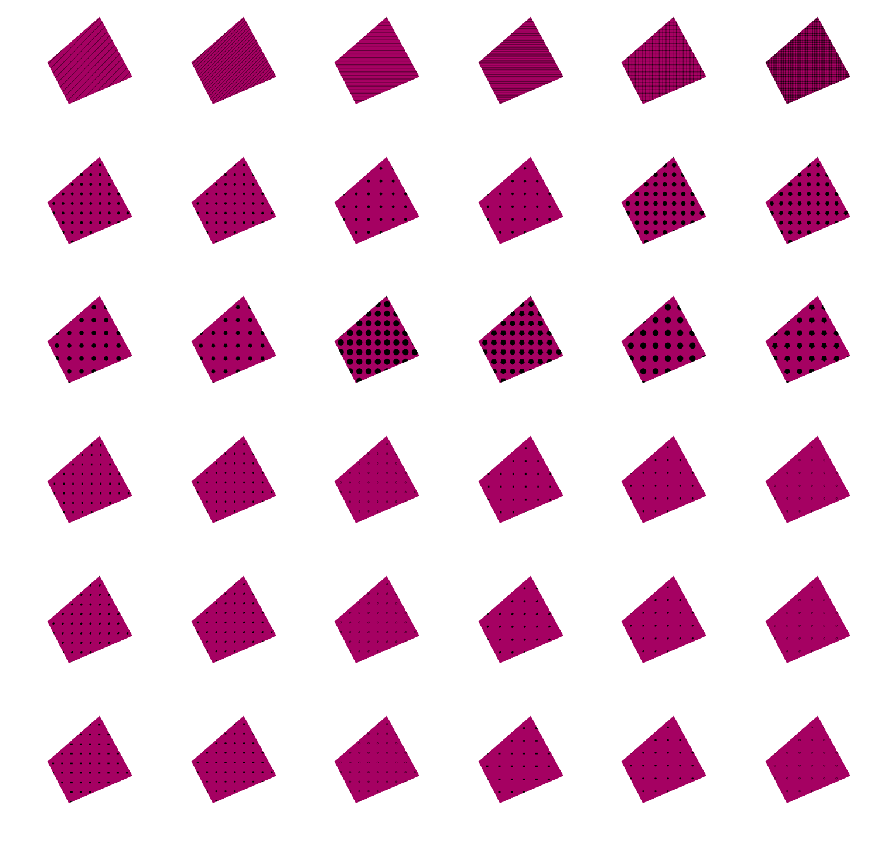

In [43]:
ncols=6
nrows=6
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,15))
for i in range(nrows):
    for j in range(ncols):
        show_img(axes[i,j], X[ncols*i+j])
plt.show()